# Forecasting with ARMA Models

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/05-ARMA-Forecast-Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Class Version In Colab"/>Class Version</a>


In [1]:
# A purely random process with a standard deviation of 1

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# AR(1) parameters
phi_1 = 0.8  # AR coefficient
phi_2 = -0.6
theta_1 = 0.6  # MA coefficient
theta_2 = -0.4
sigma = 1  # standard deviation of noise
n = 100

noise = arma_generate_sample(ar=[1], ma=[1], nsample=n, scale=sigma)
ar1 = arma_generate_sample(ar=[1, -phi_1], ma=[1], nsample=n, scale=sigma)
ar2 = arma_generate_sample(ar=[1, -phi_1, -phi_2], ma=[1], nsample=n, scale=sigma)
ma1 = arma_generate_sample(ar=[1], ma=[1, theta_1], nsample=n, scale=sigma)
ma2 = arma_generate_sample(ar=[1], ma=[1, theta_1, theta_2], nsample=n, scale=sigma)

## Fitting AR(p) Models

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t
$$

where $e_t \sim N(0, \sigma_e^2), E(e_t e_{t-k}) = 0 \text{ for } k \neq 0$.

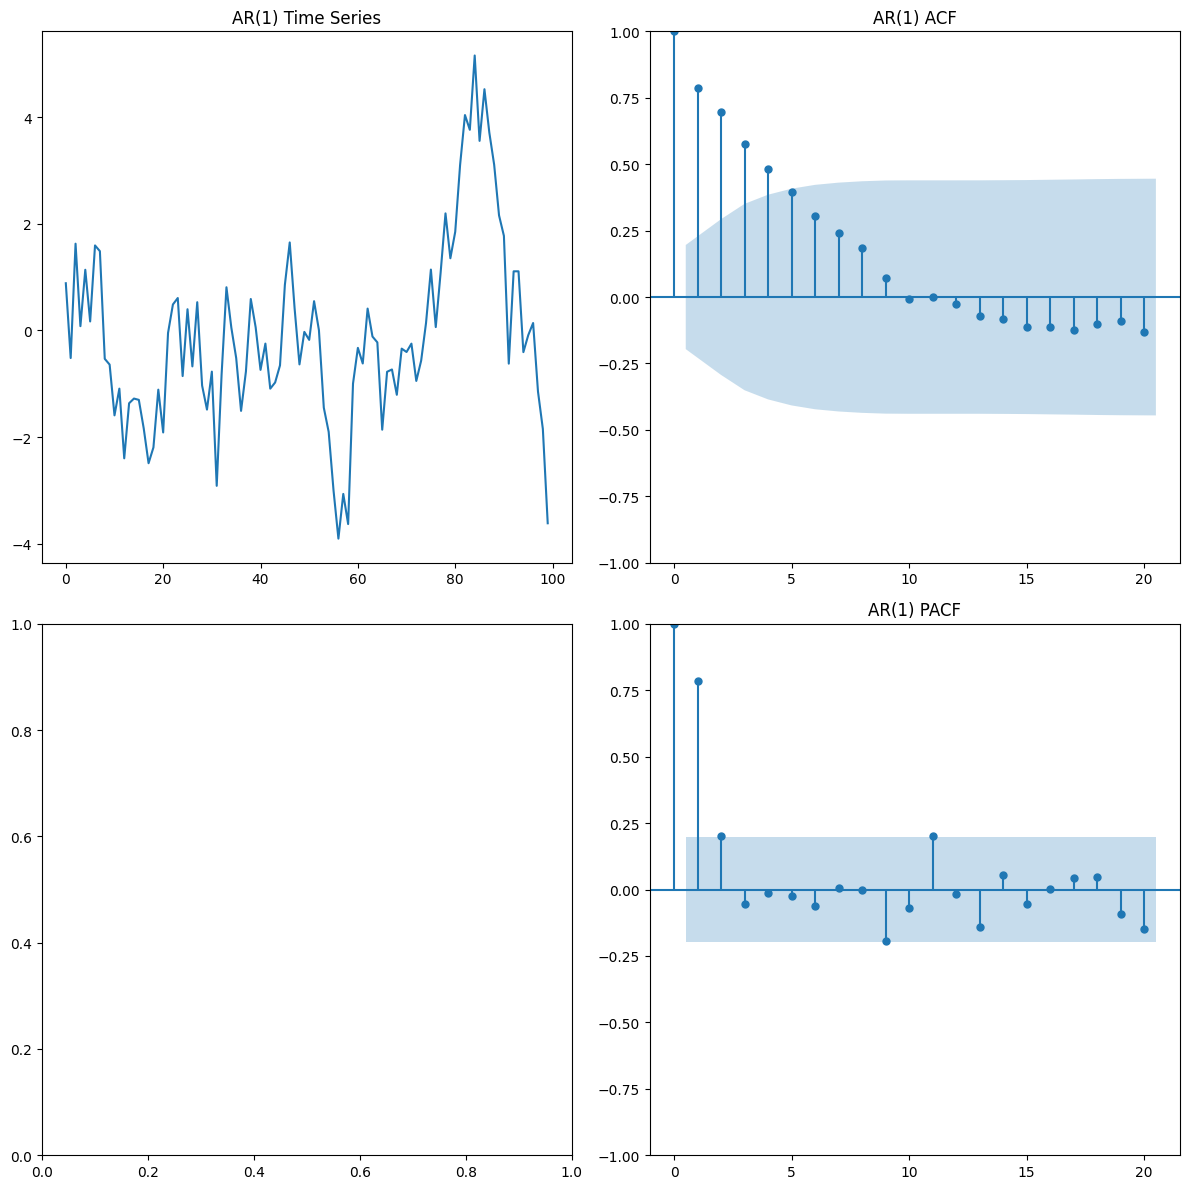

In [2]:
# Plot the ar1 series and its ACF and PACF

fix, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(ar1)
ax[0, 0].set_title('AR(1) Time Series')
plot_acf(ar1, ax=ax[0, 1], lags=20)
ax[0, 1].set_title('AR(1) ACF')
plot_pacf(ar1, ax=ax[1, 1], lags=20)
ax[1, 1].set_title('AR(1) PACF')
plt.tight_layout()
plt.show()

In [ ]:
# Use statsmodels to fit an AR(1) model and print the summary

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

model_ar1 = ARIMA(ar1, order=(1, 0, 0))
model_ar1_fit = model_ar1.fit()

print(model_ar1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -144.884
Date:                Sun, 09 Nov 2025   AIC                            295.768
Time:                        20:42:59   BIC                            303.583
Sample:                             0   HQIC                           298.931
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2084      0.543     -0.384      0.701      -1.273       0.856
ar.L1          0.8140      0.056     14.475      0.000       0.704       0.924
sigma2         1.0501      0.188      5.574      0.0

Theoretical mean: -1.1604
Sample mean: -0.1071
Using your formulas:
-0.2084 / (1 - 0.8204) = -1.1604
-0.0584 / (1 - 0.8204) = -0.3252


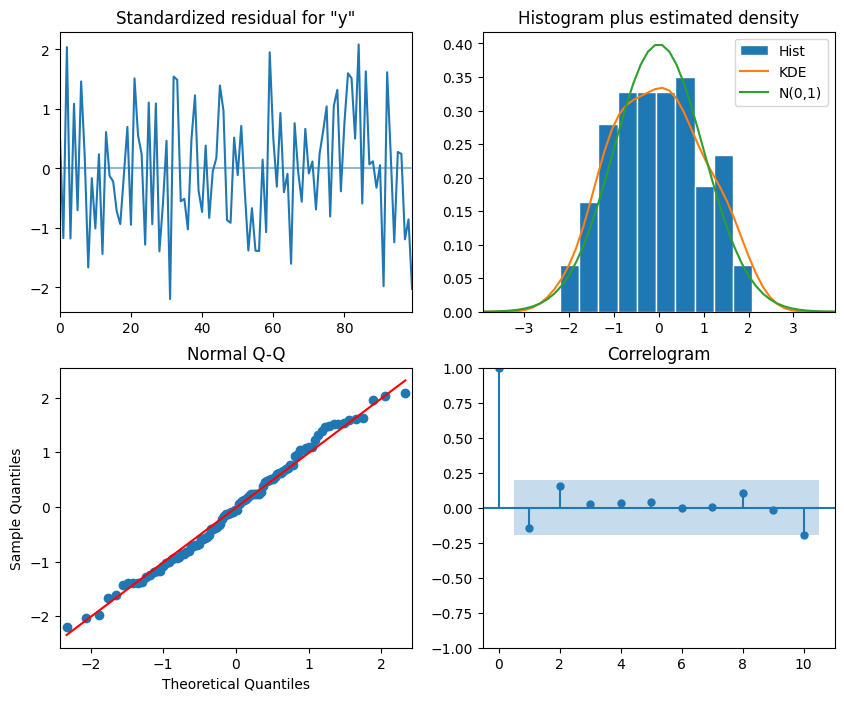

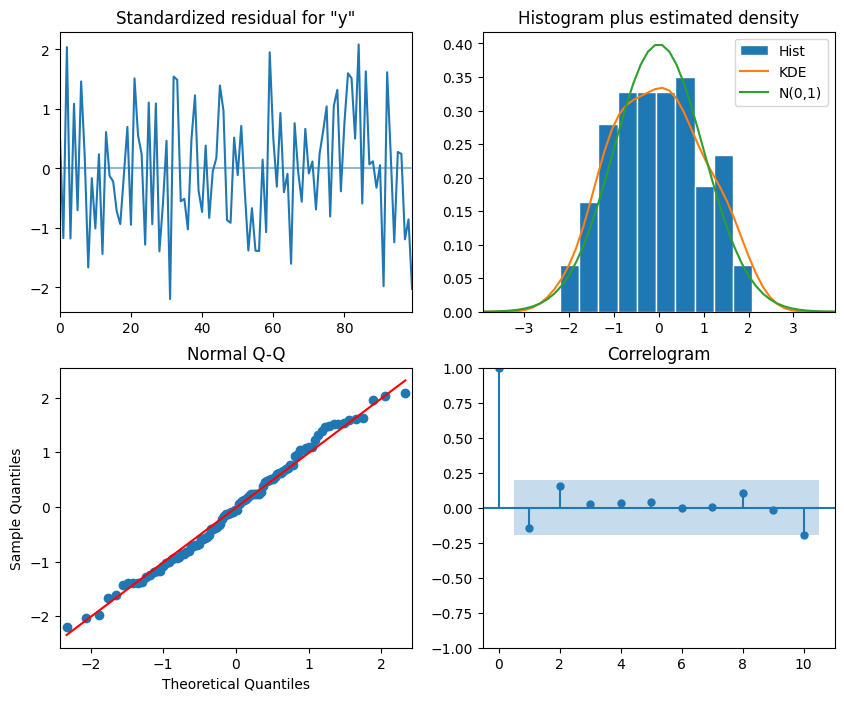

In [37]:
model_ar1_fit.plot_diagnostics(figsize=(10, 8))

In [32]:
np.mean(ar1)

np.float64(-0.10710467244059256)

In [34]:
-0.2084 / (1 + 0.8204)

-0.11448033399252912

In [25]:
-0.0584 / (1 - 0.8204)

-0.3251670378619154

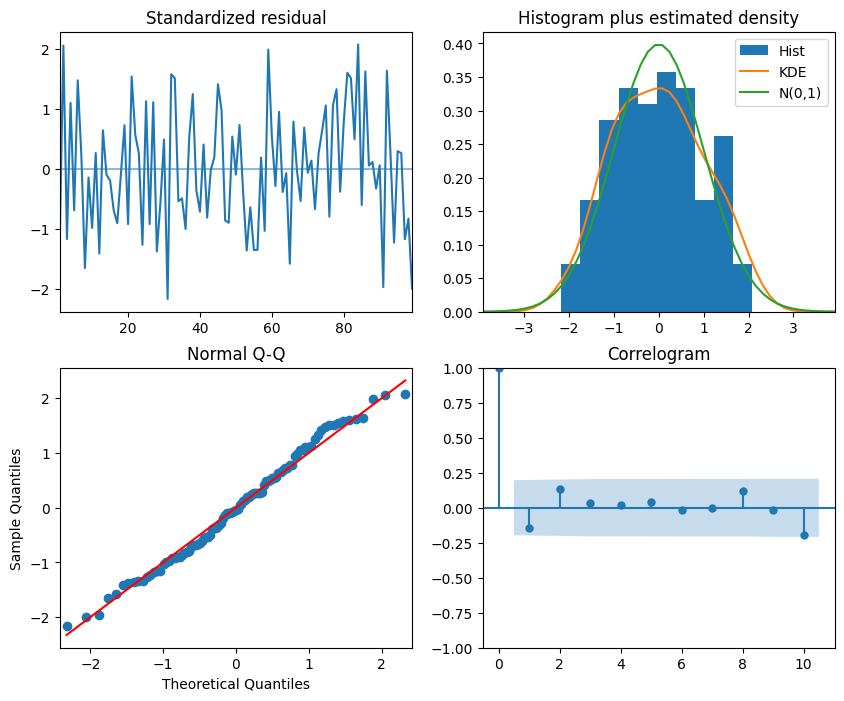

In [22]:
# Plot the residual diagnostics for the residuals

model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [21]:
from statsmodels import api as sm

# Ljung-Box test
lb = sm.stats.acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)
print(lb)

      lb_stat  lb_pvalue
10  10.120589   0.429978


In [10]:
# Use statsforecast to fit an AR(0), AR(1), AR(2), AR(3) models to the ar1 data

from statsforecast.models import AutoRegressive
from statsforecast import StatsForecast
import pandas as pd

# Bring the data into a DataFrame with the statsforecast format

df = pd.DataFrame(
    {
        'ds': pd.date_range(start='2020-01-01', periods=n, freq='D'), 
        'unique_id': 'series_ar1', 
        'y': ar1
    }
)

sf = StatsForecast(
    models=[
        AutoRegressive(lags=0, alias='AR0'),
        AutoRegressive(lags=1, alias='AR1'),
        AutoRegressive(lags=2, alias='AR2'),
        AutoRegressive(lags=3, alias='AR3')
        ], 
    freq='D')

sf.fit(df)

# Show the fitted parameters
results = sf.forecast(h=1, df=df)
print(results)


    unique_id         ds       AR0       AR1       AR2       AR3
0  series_ar1 2020-04-10 -0.107105 -2.985047 -2.776877 -2.837676


In [11]:
# Print the model summary for each model

for model in sf.models:
    print(model.alias)
    print(model.summary())

AR0


AttributeError: 'AutoRegressive' object has no attribute 'summary'